# Задание 1.2 - Линейный классификатор (Linear classifier)

В этом задании мы реализуем другую модель машинного обучения - линейный классификатор. Линейный классификатор подбирает для каждого класса веса, на которые нужно умножить значение каждого признака и потом сложить вместе.
Тот класс, у которого эта сумма больше, и является предсказанием модели.

В этом задании вы:
- потренируетесь считать градиенты различных многомерных функций
- реализуете подсчет градиентов через линейную модель и функцию потерь softmax
- реализуете процесс тренировки линейного классификатора
- подберете параметры тренировки на практике

На всякий случай, еще раз ссылка на туториал по numpy:  
http://cs231n.github.io/python-numpy-tutorial/

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_gradient
from metrics import multiclass_accuracy 
import linear_classifer

# Как всегда, первым делом загружаем данные

Мы будем использовать все тот же SVHN.

In [3]:
def prepare_for_linear_classifier(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    # Add another channel with ones as a bias term
    train_flat_with_ones = np.hstack([train_flat, np.ones((train_X.shape[0], 1))])
    test_flat_with_ones = np.hstack([test_flat, np.ones((test_X.shape[0], 1))])    
    return train_flat_with_ones, test_flat_with_ones
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_linear_classifier(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Играемся с градиентами!

В этом курсе мы будем писать много функций, которые вычисляют градиенты аналитическим методом.

Все функции, в которых мы будем вычислять градиенты, будут написаны по одной и той же схеме.  
Они будут получать на вход точку, где нужно вычислить значение и градиент функции, а на выходе будут выдавать кортеж (tuple) из двух значений - собственно значения функции в этой точке (всегда одно число) и аналитического значения градиента в той же точке (той же размерности, что и вход).
```
def f(x):
    """
    Computes function and analytic gradient at x
    
    x: np array of float, input to the function
    
    Returns:
    value: float, value of the function 
    grad: np array of float, same shape as x
    """
    ...
    
    return value, grad
```

Необходимым инструментом во время реализации кода, вычисляющего градиенты, является функция его проверки. Эта функция вычисляет градиент численным методом и сверяет результат с градиентом, вычисленным аналитическим методом.

Мы начнем с того, чтобы реализовать вычисление численного градиента (numeric gradient) в функции `check_gradient` в `gradient_check.py`. Эта функция будет принимать на вход функции формата, заданного выше, использовать значение `value` для вычисления численного градиента и сравнит его с аналитическим - они должны сходиться.

Напишите часть функции, которая вычисляет градиент с помощью численной производной для каждой координаты. Для вычисления производной используйте так называемую two-point formula (https://en.wikipedia.org/wiki/Numerical_differentiation):

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/22fc2c0a66c63560a349604f8b6b39221566236d)

Все функции приведенные в следующей клетке должны проходить gradient check.

In [7]:
# TODO: Implement check_gradient function in gradient_check.py
# All the functions below should pass the gradient check

def square(x):
    return float(x*x), 2*x

check_gradient(square, np.array([3.0]))

def array_sum(x):
    assert x.shape == (2,), x.shape
    return np.sum(x), np.ones_like(x)

check_gradient(array_sum, np.array([3.0, 2.0]))

def array_2d_sum(x):
    assert x.shape == (2,2)
    return np.sum(x), np.ones_like(x)

check_gradient(array_2d_sum, np.array([[3.0, 2.0], [1.0, 0.0]]))

Gradient check passed!
Gradient check passed!
Gradient check passed!


True

## Начинаем писать свои функции, считающие аналитический градиент

Теперь реализуем функцию softmax, которая получает на вход оценки для каждого класса и преобразует их в вероятности от 0 до 1:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/e348290cf48ddbb6e9a6ef4e39363568b67c09d3)

**Важно:** Практический аспект вычисления этой функции заключается в том, что в ней учавствует вычисление экспоненты от потенциально очень больших чисел - это может привести к очень большим значениям в числителе и знаменателе за пределами диапазона float.

К счастью, у этой проблемы есть простое решение -- перед вычислением softmax вычесть из всех оценок максимальное значение среди всех оценок:
```
predictions -= np.max(predictions)
```
(подробнее здесь - http://cs231n.github.io/linear-classify/#softmax, секция `Practical issues: Numeric stability`)

In [8]:
# TODO Implement softmax and cross-entropy for single sample
probs = linear_classifer.softmax(np.array([-10, 0, 10]))

# Make sure it works for big numbers too!
probs = linear_classifer.softmax(np.array([1000, 0, 0]))
assert np.isclose(probs[0], 1.0)

Кроме этого, мы реализуем cross-entropy loss, которую мы будем использовать как функцию ошибки (error function).
В общем виде cross-entropy определена следующим образом:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/0cb6da032ab424eefdca0884cd4113fe578f4293)

где x - все классы, p(x) - истинная вероятность принадлежности сэмпла классу x, а q(x) - вероятность принадлежности классу x, предсказанная моделью.  
В нашем случае сэмпл принадлежит только одному классу, индекс которого передается функции. Для него p(x) равна 1, а для остальных классов - 0. 

Это позволяет реализовать функцию проще!

In [9]:
probs = linear_classifer.softmax(np.array([-5, 0, 5]))
linear_classifer.cross_entropy_loss(probs, 1)

5.006760443547122

После того как мы реализовали сами функции, мы можем реализовать градиент.

Оказывается, что вычисление градиента становится гораздо проще, если объединить эти функции в одну, которая сначала вычисляет вероятности через softmax, а потом использует их для вычисления функции ошибки через cross-entropy loss.

Эта функция `softmax_with_cross_entropy` будет возвращает и значение ошибки, и градиент по входным параметрам. Мы проверим корректность реализации с помощью `check_gradient`.

In [12]:
# TODO Implement combined function or softmax and cross entropy and produces gradient
loss, grad = linear_classifer.softmax_with_cross_entropy(np.array([1, 0, 0]), 1)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, 1), np.array([1, 0, 0], np.float))

Gradient check passed!


True

В качестве метода тренировки мы будем использовать стохастический градиентный спуск (stochastic gradient descent или SGD), который работает с батчами сэмплов. 

Поэтому все наши фукнции будут получать не один пример, а батч, то есть входом будет не вектор из `num_classes` оценок, а матрица размерности `batch_size, num_classes`. Индекс примера в батче всегда будет первым измерением.

Следующий шаг - переписать наши функции так, чтобы они поддерживали батчи.

Финальное значение функции ошибки должно остаться числом, и оно равно среднему значению ошибки среди всех примеров в батче.

In [13]:
# TODO Extend combined function so it can receive a 2d array with batch of samples
np.random.seed(42)
# Test batch_size = 1
num_classes = 4
batch_size = 1
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Test batch_size = 3
num_classes = 4
batch_size = 3
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Make sure maximum subtraction for numberic stability is done separately for every sample in the batch
probs = linear_classifer.softmax(np.array([[20,0,0], [1000, 0, 0]]))
assert np.all(np.isclose(probs[:, 0], 1.0))

Gradient check passed!
Gradient check passed!


### Наконец, реализуем сам линейный классификатор!

softmax и cross-entropy получают на вход оценки, которые выдает линейный классификатор.

Он делает это очень просто: для каждого класса есть набор весов, на которые надо умножить пиксели картинки и сложить. Получившееся число и является оценкой класса, идущей на вход softmax.

Таким образом, линейный классификатор можно представить как умножение вектора с пикселями на матрицу W размера `num_features, num_classes`. Такой подход легко расширяется на случай батча векторов с пикселями X размера `batch_size, num_features`:

`predictions = X * W`, где `*` - матричное умножение.

Реализуйте функцию подсчета линейного классификатора и градиентов по весам `linear_softmax` в файле `linear_classifer.py`

In [14]:
# TODO Implement linear_softmax function that uses softmax with cross-entropy for linear classifier
batch_size = 2
num_classes = 2
num_features = 3
np.random.seed(42)
W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(np.float)
X = np.random.randint(-1, 3, size=(batch_size, num_features)).astype(np.float)
target_index = np.ones(batch_size, dtype=np.int)

loss, dW = linear_classifer.linear_softmax(X, W, target_index)
check_gradient(lambda w: linear_classifer.linear_softmax(X, w, target_index), W)

Gradient check passed!


True

### И теперь регуляризация

Мы будем использовать L2 regularization для весов как часть общей функции ошибки.

Напомним, L2 regularization определяется как

l2_reg_loss = regularization_strength * sum<sub>ij</sub> W[i, j]<sup>2</sup>

Реализуйте функцию для его вычисления и вычисления соотвествующих градиентов.

In [15]:
# TODO Implement l2_regularization function that implements loss for L2 regularization
linear_classifer.l2_regularization(W, 0.01)
check_gradient(lambda w: linear_classifer.l2_regularization(w, 0.01), W)

Gradient check passed!


True

# Тренировка!

Градиенты в порядке, реализуем процесс тренировки!

In [16]:
# TODO: Implement LinearSoftmaxClassifier.fit function
classifier = linear_classifer.LinearSoftmaxClassifier()
loss_history = classifier.fit(train_X, train_y, epochs=10, learning_rate=1e-3, batch_size=300, reg=1e1)

Epoch 0, loss: 691.126734
Epoch 1, loss: 717.019993
Epoch 2, loss: 742.517739
Epoch 3, loss: 767.434835
Epoch 4, loss: 781.312402
Epoch 5, loss: 751.616065
Epoch 6, loss: 741.137412
Epoch 7, loss: 799.083768
Epoch 8, loss: 912.039534
Epoch 9, loss: 947.064208


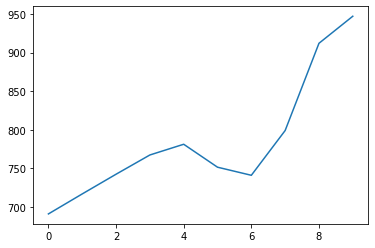

In [17]:
# let's look at the loss history!
plt.plot(loss_history)

In [19]:
# Let's check how it performs on validation set
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy: ", accuracy)

# Now, let's train more and see if it performs better
classifier.fit(train_X, train_y, epochs=100, learning_rate=1e-3, batch_size=300, reg=1e1)
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy after training for 100 epochs: ", accuracy)

Accuracy:  0.146
Epoch 0, loss: 713.445531
Epoch 1, loss: 719.195132
Epoch 2, loss: 713.910978
Epoch 3, loss: 727.410103
Epoch 4, loss: 749.326307
Epoch 5, loss: 837.423965
Epoch 6, loss: 1018.506335
Epoch 7, loss: 1390.977540
Epoch 8, loss: 1067.984933
Epoch 9, loss: 1019.505285
Epoch 10, loss: 1001.378783
Epoch 11, loss: 937.158608
Epoch 12, loss: 914.534530
Epoch 13, loss: 871.930016
Epoch 14, loss: 790.971990
Epoch 15, loss: 797.761611
Epoch 16, loss: 842.667193
Epoch 17, loss: 909.083294
Epoch 18, loss: 977.683611
Epoch 19, loss: 732.855889
Epoch 20, loss: 790.471729
Epoch 21, loss: 796.253121
Epoch 22, loss: 892.691976
Epoch 23, loss: 1015.739307
Epoch 24, loss: 791.692767
Epoch 25, loss: 798.720621
Epoch 26, loss: 943.640671
Epoch 27, loss: 901.906725
Epoch 28, loss: 874.624438
Epoch 29, loss: 854.149489
Epoch 30, loss: 866.985139
Epoch 31, loss: 943.287905
Epoch 32, loss: 1012.480541
Epoch 33, loss: 970.016200
Epoch 34, loss: 896.244224
Epoch 35, loss: 977.069521
Epoch 36, loss

### Как и раньше, используем кросс-валидацию для подбора гиперпараметтов.

В этот раз, чтобы тренировка занимала разумное время, мы будем использовать только одно разделение на тренировочные (training) и проверочные (validation) данные.

Теперь нам нужно подобрать не один, а два гиперпараметра! Не ограничивайте себя изначальными значениями в коде.  
Добейтесь точности более чем **20%** на проверочных данных (validation data).

In [21]:
num_epochs = 200
batch_size = 300

learning_rates = [1e-3, 1e-4, 1e-5]
reg_strengths = [1e-4, 1e-5, 1e-6]

best_classifier = None
best_val_accuracy = None

# TODO use validation set to find the best hyperparameters
# hint: for best results, you might need to try more values for learning rate and regularization strength 
# than provided initially
for lr in learning_rates:
    classifier = linear_classifer.LinearSoftmaxClassifier()
    for reg in reg_strengths:
        classifier.fit(train_X, train_y, epochs=num_epochs,
                      learning_rate=lr, batch_size=batch_size, reg=reg)
        prediction = classifier.predict(val_X)
        accuracy = multiclass_accuracy(prediction, val_y)
        if not best_val_accuracy or accuracy > best_val_accuracy:
            best_val_accuracy = accuracy
            best_classifier = (lr, reg)

print('best validation accuracy achieved: %f' % best_val_accuracy)

Epoch 0, loss: 690.501273
Epoch 1, loss: 718.707597
Epoch 2, loss: 741.726298
Epoch 3, loss: 735.583084
Epoch 4, loss: 762.983747
Epoch 5, loss: 749.831946
Epoch 6, loss: 749.628129
Epoch 7, loss: 793.681897
Epoch 8, loss: 873.016222
Epoch 9, loss: 889.714694
Epoch 10, loss: 913.934917
Epoch 11, loss: 865.572821
Epoch 12, loss: 831.158274
Epoch 13, loss: 881.279711
Epoch 14, loss: 1004.214847
Epoch 15, loss: 894.025236
Epoch 16, loss: 1009.999662
Epoch 17, loss: 1004.971168
Epoch 18, loss: 1039.482164
Epoch 19, loss: 977.419734
Epoch 20, loss: 936.055854
Epoch 21, loss: 965.713103
Epoch 22, loss: 947.438042
Epoch 23, loss: 729.064624
Epoch 24, loss: 700.478095
Epoch 25, loss: 713.552574
Epoch 26, loss: 746.882101
Epoch 27, loss: 853.458697
Epoch 28, loss: 1044.272292
Epoch 29, loss: 952.920357
Epoch 30, loss: 766.052627
Epoch 31, loss: 793.717350
Epoch 32, loss: 857.629244
Epoch 33, loss: 917.660322
Epoch 34, loss: 903.328182
Epoch 35, loss: 897.649874
Epoch 36, loss: 764.262190
Epoch 

Epoch 112, loss: 855.631110
Epoch 113, loss: 860.118754
Epoch 114, loss: 734.169140
Epoch 115, loss: 826.173123
Epoch 116, loss: 816.309459
Epoch 117, loss: 814.769060
Epoch 118, loss: 849.054298
Epoch 119, loss: 775.216932
Epoch 120, loss: 712.807350
Epoch 121, loss: 753.257931
Epoch 122, loss: 742.103263
Epoch 123, loss: 742.319054
Epoch 124, loss: 857.124015
Epoch 125, loss: 891.106511
Epoch 126, loss: 989.302360
Epoch 127, loss: 992.156376
Epoch 128, loss: 957.972094
Epoch 129, loss: 886.234440
Epoch 130, loss: 768.004850
Epoch 131, loss: 762.386805
Epoch 132, loss: 709.378363
Epoch 133, loss: 734.792872
Epoch 134, loss: 746.182593
Epoch 135, loss: 841.095575
Epoch 136, loss: 986.446680
Epoch 137, loss: 1147.348881
Epoch 138, loss: 803.169453
Epoch 139, loss: 806.215648
Epoch 140, loss: 771.554619
Epoch 141, loss: 906.306918
Epoch 142, loss: 830.515647
Epoch 143, loss: 745.874772
Epoch 144, loss: 753.184280
Epoch 145, loss: 774.483761
Epoch 146, loss: 809.037958
Epoch 147, loss: 75

Epoch 15, loss: 684.843753
Epoch 16, loss: 686.098998
Epoch 17, loss: 684.149194
Epoch 18, loss: 687.898496
Epoch 19, loss: 685.033926
Epoch 20, loss: 684.052563
Epoch 21, loss: 689.808307
Epoch 22, loss: 688.258003
Epoch 23, loss: 687.366217
Epoch 24, loss: 686.487117
Epoch 25, loss: 684.655190
Epoch 26, loss: 684.908529
Epoch 27, loss: 686.396232
Epoch 28, loss: 683.311065
Epoch 29, loss: 685.663071
Epoch 30, loss: 685.198996
Epoch 31, loss: 683.297227
Epoch 32, loss: 684.081846
Epoch 33, loss: 686.282132
Epoch 34, loss: 681.114005
Epoch 35, loss: 683.138365
Epoch 36, loss: 684.150371
Epoch 37, loss: 685.256442
Epoch 38, loss: 683.304053
Epoch 39, loss: 680.992053
Epoch 40, loss: 677.682077
Epoch 41, loss: 680.142799
Epoch 42, loss: 681.380325
Epoch 43, loss: 680.000634
Epoch 44, loss: 682.064486
Epoch 45, loss: 679.604558
Epoch 46, loss: 676.661525
Epoch 47, loss: 682.007495
Epoch 48, loss: 681.837590
Epoch 49, loss: 680.923360
Epoch 50, loss: 682.712099
Epoch 51, loss: 679.196066
E

Epoch 118, loss: 656.669507
Epoch 119, loss: 645.500783
Epoch 120, loss: 650.996431
Epoch 121, loss: 658.492108
Epoch 122, loss: 640.387413
Epoch 123, loss: 655.171862
Epoch 124, loss: 652.528817
Epoch 125, loss: 650.875451
Epoch 126, loss: 640.347783
Epoch 127, loss: 648.006202
Epoch 128, loss: 653.390106
Epoch 129, loss: 649.668066
Epoch 130, loss: 651.958366
Epoch 131, loss: 661.939592
Epoch 132, loss: 651.909596
Epoch 133, loss: 654.644198
Epoch 134, loss: 655.786025
Epoch 135, loss: 660.750075
Epoch 136, loss: 641.709360
Epoch 137, loss: 653.187099
Epoch 138, loss: 656.342939
Epoch 139, loss: 646.660299
Epoch 140, loss: 654.636211
Epoch 141, loss: 653.110557
Epoch 142, loss: 659.168436
Epoch 143, loss: 655.184698
Epoch 144, loss: 658.731947
Epoch 145, loss: 655.207197
Epoch 146, loss: 645.576900
Epoch 147, loss: 645.608717
Epoch 148, loss: 647.465244
Epoch 149, loss: 634.237116
Epoch 150, loss: 651.507572
Epoch 151, loss: 649.478951
Epoch 152, loss: 646.265464
Epoch 153, loss: 646

Epoch 17, loss: 690.528638
Epoch 18, loss: 690.090798
Epoch 19, loss: 689.919772
Epoch 20, loss: 691.214169
Epoch 21, loss: 690.007092
Epoch 22, loss: 690.394051
Epoch 23, loss: 689.767391
Epoch 24, loss: 690.614119
Epoch 25, loss: 690.036958
Epoch 26, loss: 690.055921
Epoch 27, loss: 689.882175
Epoch 28, loss: 689.880745
Epoch 29, loss: 689.587239
Epoch 30, loss: 689.803897
Epoch 31, loss: 690.216083
Epoch 32, loss: 689.831058
Epoch 33, loss: 690.404468
Epoch 34, loss: 690.037343
Epoch 35, loss: 689.802710
Epoch 36, loss: 690.271749
Epoch 37, loss: 689.350857
Epoch 38, loss: 689.797142
Epoch 39, loss: 690.329832
Epoch 40, loss: 689.811020
Epoch 41, loss: 689.808062
Epoch 42, loss: 689.668748
Epoch 43, loss: 689.405672
Epoch 44, loss: 689.726002
Epoch 45, loss: 689.913536
Epoch 46, loss: 689.879739
Epoch 47, loss: 689.722518
Epoch 48, loss: 689.845075
Epoch 49, loss: 690.145186
Epoch 50, loss: 689.322708
Epoch 51, loss: 689.598793
Epoch 52, loss: 688.671524
Epoch 53, loss: 688.962086
E

Epoch 122, loss: 682.601234
Epoch 123, loss: 683.797876
Epoch 124, loss: 682.796150
Epoch 125, loss: 685.070387
Epoch 126, loss: 681.904131
Epoch 127, loss: 684.489542
Epoch 128, loss: 683.209355
Epoch 129, loss: 682.761686
Epoch 130, loss: 681.840842
Epoch 131, loss: 683.967345
Epoch 132, loss: 681.305231
Epoch 133, loss: 681.505905
Epoch 134, loss: 678.514407
Epoch 135, loss: 683.437076
Epoch 136, loss: 684.377887
Epoch 137, loss: 683.053469
Epoch 138, loss: 681.986811
Epoch 139, loss: 681.659584
Epoch 140, loss: 681.408918
Epoch 141, loss: 680.975653
Epoch 142, loss: 682.191118
Epoch 143, loss: 682.480880
Epoch 144, loss: 682.434960
Epoch 145, loss: 681.474085
Epoch 146, loss: 682.713979
Epoch 147, loss: 683.201861
Epoch 148, loss: 683.762229
Epoch 149, loss: 681.924517
Epoch 150, loss: 680.912914
Epoch 151, loss: 679.805582
Epoch 152, loss: 681.223159
Epoch 153, loss: 681.327566
Epoch 154, loss: 679.363871
Epoch 155, loss: 683.354197
Epoch 156, loss: 683.775205
Epoch 157, loss: 684

# Какой же точности мы добились на тестовых данных?

In [ ]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Linear softmax classifier test set accuracy: %f' % (test_accuracy, ))